## [Our DDSP project in Github](https://github.com/XinjianOUYANG/Pole_Projet_DDSP)

# DDSP synthesizer

Evaluate the generation quality of the DDSP synthesizer using the GMM from T3.2 and predefined pitch and loudness profiles.

####  Expected outcome of T3: 
A fully generative model based on DDSP which can generate musical sounds without any input audio signal

## Install Dependencies

In [1]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds 
import ddsp
import utils
import os
import gin
import pickle
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
 
%matplotlib inline
sample_rate = 16000

## Set the path of audio and model

In [2]:
# audio path
audio_path = 'Datasets/Piano/Audio/Piano_01.wav'

**the model trained with z encoder**

In [3]:
# model folder direction 
model_dir_z = 'Pretrained_Models_for_T2/piano_ae'
# dataset_statistics.pkl in .model folder
dataset_stats_file_z = os.path.join(model_dir_z, 'dataset_statistics.pkl')
# operative_config-0.gin in model folder
gin_file_z = os.path.join(model_dir_z, 'operative_config-0.gin')

## Read audios and computing (f0,loudness,MFCC)

### Use the given python file [spectral_ops.py](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in ddsp library to compute $f0$ and loudness.
* *ddsp.spectral_ops.compute_f0*

* *ddsp.spectral_ops.compute_loudness*

In [4]:
print(audio_path)
x_all, sr = sf.read(audio_path) #data,samplerate
print('shape of original signal:',np.shape(x_all),'\n','original sample rate:',sr)
sig = x_all[:] # choose the first channel of the original audio
 
# resample (down sampling to 16kHz) and take the 10-20 seconds
sig_re = librosa.resample(sig,sr,sample_rate)
audio = sig_re[15*sample_rate:25*sample_rate]
print('audio shape:',np.shape(audio))
audio = audio[np.newaxis,:]

# # plot wave form
# T_all = audio.shape[1]
# time = np.arange(T_all)/sample_rate
# plt.figure(figsize=(9,3))
# plt.plot(time, audio[0])
# plt.xlabel('time (s)')
# plt.ylabel('amplitude')

# # Calculate Spectrogram and plot
# utils.specplot(audio)

Datasets/Piano/Audio/Piano_01.wav
shape of original signal: (960000,) 
 original sample rate: 16000
audio shape: (160000,)


In [5]:
# play audio
ipd.Audio(audio[0], rate = sample_rate)

In [6]:
#extracting f0 with CREPE
ddsp.spectral_ops.reset_crepe()
f0_crepe, f0_confidence = ddsp.spectral_ops.compute_f0(audio[0], 
                                                       sample_rate= sample_rate,
                                                       frame_rate=100,
                                                       viterbi=False)
#extracting loudness 
loudness =ddsp.spectral_ops.compute_loudness(audio[0],
                     sample_rate= sample_rate,
                     frame_rate=250,
                     n_fft=2048,
                     ref_db=20.7,
                     use_tf=False)

# audio_features dictionary
audio_features_key = ['audio','f0_hz','f0_confidence','loudness_db']
audio_features = dict([(k,[]) for k in audio_features_key])
audio_features['audio'] = audio
audio_features['f0_hz'] = f0_crepe
audio_features['f0_confidence'] = f0_confidence
audio_features['loudness_db'] = loudness

# # Plot Pitch/f0.
# plt.figure(figsize=(6, 4))
# f0_crepe_midi = ddsp.core.hz_to_midi(f0_crepe)
# plt.plot(np.ravel(f0_crepe), label='crepe')
# plt.ylabel('Pitch (MIDI)')
# # Plot f0_confidence.
# plt.figure(figsize=(6, 4))
# plt.plot(np.ravel(f0_confidence), label='f0 confidence')
# plt.ylabel('f0 confidence')
# # Plot Loundness.
# plt.figure(figsize=(6, 4))
# plt.plot(np.ravel(loudness), label='loudness')
# plt.ylabel('Loudness')

## Load the model

In [7]:
def model_loading(model_dir,dataset_stats_file,gin_file,audio_features,audio):
    # Load the dataset statistics.
    print(f'Loading dataset statistics from {dataset_stats_file}')
    try:
      if tf.io.gfile.exists(dataset_stats_file):
        with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
          DATASET_STATS = pickle.load(f)
    except Exception as err:
      print('Loading dataset statistics from pickle failed: {}.'.format(err))


    # Parse gin config,
    with gin.unlock_config():
      gin.parse_config_file(gin_file, skip_unknown=True)

    # Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
    ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
    ckpt_name = ckpt_files[0].split('.')[0]
    ckpt = os.path.join(model_dir, ckpt_name)

    # Ensure dimensions and sampling rates are equal
    time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
    n_samples_train = gin.query_parameter('Harmonic.n_samples')
    hop_size = int(n_samples_train / time_steps_train)

    time_steps = int(audio.shape[1] / hop_size)
    n_samples = time_steps * hop_size

    # print("===Trained model===")
    # print("Time Steps", time_steps_train)
    # print("Samples", n_samples_train)
    # print("Hop Size", hop_size)
    # print("\n===Resynthesis===")
    # print("Time Steps", time_steps)
    # print("Samples", n_samples)
    # print('')

    gin_params = [
        'Harmonic.n_samples = {}'.format(n_samples),
        'FilteredNoise.n_samples = {}'.format(n_samples),
        'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
        'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
    ]

    with gin.unlock_config():
      gin.parse_config(gin_params)

    # Trim all input vectors to correct lengths 
    for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
      audio_features[key] = audio_features[key][:time_steps]
    audio_features['audio'] = audio_features['audio'][:n_samples]

    # Set up the model just to predict audio given new conditioning
    model = ddsp.training.models.Autoencoder()
    model.restore(ckpt)
    # Resynthesize audio.
    outputs = model(audio_features, training=False) # Run the forward pass, add losses, and create a dictionary of outputs.
    audio_gen = outputs['audio_synth']
    
    return audio_gen, outputs, model

In [8]:
# load the model with z encoder
print(model_dir_z,'\n',dataset_stats_file_z,'\n',gin_file_z)
audio_gen_z, outputs_z, model_z = model_loading(model_dir_z,dataset_stats_file_z,gin_file_z,audio_features,audio)

Pretrained_Models_for_T2/piano_ae 
 Pretrained_Models_for_T2/piano_ae/dataset_statistics.pkl 
 Pretrained_Models_for_T2/piano_ae/operative_config-0.gin
Loading dataset statistics from Pretrained_Models_for_T2/piano_ae/dataset_statistics.pkl


### Extract feature z from the model

In [9]:
z_feature = outputs_z['z']

print(outputs_z.keys())
print('\n shape of z:',np.shape(z_feature),'\n')
print(np.shape(audio_features['f0_hz']), np.shape(outputs_z['f0_hz']))
print(np.shape(audio_features['loudness_db']), np.shape(outputs_z['loudness_db']))

# print(audio_features['f0_hz'],outputs_z['f0_hz'],audio_features['loudness_db'],outputs_z['loudness_db'][0])
# print('\n',outputs_z['inputs'].keys())

dict_keys(['inputs', 'audio', 'f0_hz', 'f0_confidence', 'loudness_db', 'f0_scaled', 'ld_scaled', 'z', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'filtered_noise', 'add', 'out', 'audio_synth'])

 shape of z: (1, 2500, 16) 

(1000,) (1, 2500, 1)
(2500,) (1, 2500, 1)


# Synthesize pitch, loudness and z features

#### References
* [autoencoder.py](https://github.com/magenta/ddsp/blob/master/ddsp/training/models/autoencoder.py)
* [Scale f0, ld](https://github.com/magenta/ddsp/blob/master/ddsp/training/preprocessing.py)
* [processor_group](https://github.com/magenta/ddsp/blob/d9124662d4e836a7665039f98e7421b9dd9a4178/ddsp/processors.py#L81)

In [10]:
f0_scaled = outputs_z['f0_scaled']
ld_scaled = outputs_z['ld_scaled']
f0_hz = outputs_z['f0_hz']
print('\n', np.shape(f0_scaled),np.shape(ld_scaled),np.shape(f0_hz))


 (1, 2500, 1) (1, 2500, 1) (1, 2500, 1)


### GMM over z

In [11]:
import sklearn
from sklearn.mixture import GaussianMixture

load_path = 'z_datasets/z_piano_ae.npy'

X = np.load(load_path)
print(np.shape(X))

# reduce dimensionality 
N, T_step, Z_dim = np.shape(X)[0], np.shape(X)[2], np.shape(X)[3]
X_new = np.zeros(shape=(N,T_step, Z_dim))

for i in np.arange(N):
    X_new[i] = X[i,0]
    
print(np.shape(X_new))

X_re = np.reshape(X_new,(N*T_step,16))
print(np.shape(X_re))

# fit Z and build a GMM model
N_clusters = 10
gm = GaussianMixture(n_components=N_clusters).fit(X_re)

(15, 1, 15000, 16)
(15, 15000, 16)
(225000, 16)


In [12]:
weights = gm.weights_
N_maxWeight = np.argmax(weights)
N_minWeight = np.argmin(weights)

print(weights,'\n',N_maxWeight,N_minWeight)

[0.13816836 0.09318533 0.06348097 0.08245312 0.03549824 0.08405914
 0.07753773 0.07111613 0.14340049 0.21110049] 
 9 4


In [13]:
# Predict Z
Z_frames = 2500

predictions = gm.sample(Z_frames)
Z = np.zeros(shape=(1,Z_frames, 16))
Z[0] = predictions[0]

print(np.shape(Z))

(1, 2500, 16)


## Synthesizing 

In [14]:
# i = 600
# ld_scaled_temp = ld_scaled[0][i]
# f0_scaled_temp = f0_scaled[0][i]
# f0_hz_temp = f0_hz[0][i]
# print(ld_scaled_temp,'\n', f0_scaled_temp,'\n', f0_hz_temp)

# ld_scaled2 = np.zeros(shape=(1,Z_frames, 1))
# f0_scaled2 = np.zeros(shape=(1,Z_frames, 1))
# f0_hz2 = np.zeros(shape=(1,Z_frames, 1))
# ld_scaled2[0] = ld_scaled_temp
# f0_scaled2[0] = f0_scaled_temp
# f0_hz2[0] = f0_hz_temp

# inputs_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
# inputs = dict([(k,[]) for k in inputs_keys])

# inputs['z'] = Z
# inputs['ld_scaled'] = ld_scaled2 
# inputs['f0_scaled'] = f0_scaled2 
# inputs['f0_hz'] = f0_hz2

In [15]:
inputs_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
inputs = dict([(k,[]) for k in inputs_keys])

inputs['ld_scaled'] = ld_scaled 
inputs['f0_scaled'] = f0_scaled 
inputs['f0_hz'] = f0_hz
inputs['z'] = Z

In [16]:
# input_keys=('ld_scaled', 'f0_scaled', 'z')
# 'model_z' is the pretrained model with z encoder
pg_out = model_z.decode(inputs,training = False) # pg = processor group
audio_syn = pg_out

In [17]:
ipd.Audio(audio_syn, rate = sample_rate)

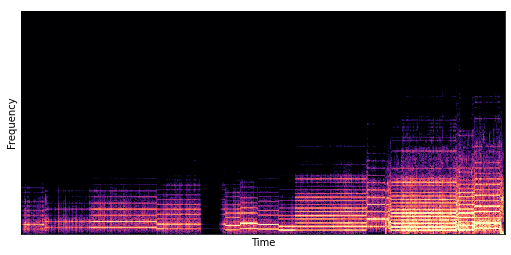

In [18]:
utils.specplot(audio_syn)

## 3 methods

### 1. fix z

In [19]:
predictions = gm.sample(1)
Z_fixed = np.zeros(shape=(1,Z_frames, 16))
Z_fixed[0] = predictions[0]

# print(Z_fixed, '\n',np.shape(Z_fixed))

In [20]:
inputs1_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
inputs1 = dict([(k,[]) for k in inputs1_keys])

inputs1['ld_scaled'] = ld_scaled 
inputs1['f0_scaled'] = f0_scaled 
inputs1['f0_hz'] = f0_hz
inputs1['z'] = Z_fixed
pg_out1 = model_z.decode(inputs1,training = False) # pg = processor group
audio_syn1 = pg_out1

In [21]:
ipd.Audio(audio_syn1, rate = sample_rate)

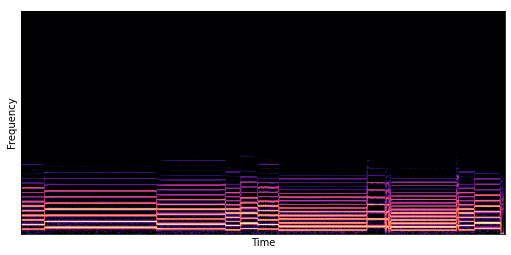

In [22]:
utils.specplot(audio_syn1)

### 2. fix f,l

In [23]:
i = 600
ld_scaled_temp = ld_scaled[0][i]
f0_scaled_temp = f0_scaled[0][i]
f0_hz_temp = f0_hz[0][i]
print(ld_scaled_temp,'\n', f0_scaled_temp,'\n', f0_hz_temp)

ld_scaled2 = np.zeros(shape=(1,Z_frames, 1))
f0_scaled2 = np.zeros(shape=(1,Z_frames, 1))
f0_hz2 = np.zeros(shape=(1,Z_frames, 1))
ld_scaled2[0] = ld_scaled_temp
f0_scaled2[0] = f0_scaled_temp
f0_hz2[0] = f0_hz_temp

inputs2_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
inputs2 = dict([(k,[]) for k in inputs2_keys])

inputs2['z'] = Z
inputs2['ld_scaled'] = ld_scaled2 
inputs2['f0_scaled'] = f0_scaled2 
inputs2['f0_hz'] = f0_hz2

# print(inputs2['ld_scaled'],'\n',inputs2['f0_scaled'],'\n',inputs2['f0_hz'])
pg_out2 = model_z.decode(inputs2,training = False) # pg = processor group
audio_syn2 = pg_out2

tf.Tensor([0.39189076], shape=(1,), dtype=float32) 
 tf.Tensor([0.4487863], shape=(1,), dtype=float32) 
 tf.Tensor([219.94737], shape=(1,), dtype=float32)


In [24]:
ipd.Audio(audio_syn2, rate = sample_rate)

### 3. Inverse transform sampling

consider only the diagonal of the covariance matrix, and apply 1D inverse transform sampling for each dimensions, using as variance the corresponding element in the diagonal of the covariance matrix
 
    norm.ppf: Percent point function (inverse of cdf — percentiles).
    The location (loc) keyword specifies the mean. 
    The scale (scale) keyword specifies the standard deviation.

In [38]:
from scipy.stats import norm

# take the gaussian of max weight from GMM
mu = gm.means_[N_maxWeight] 
cov = gm.covariances_[N_maxWeight]

# print(np.shape(cov),'\n',cov)
n_grid = Z_frames
uniform_samples = np.linspace(0.01,0.99,n_grid) # linearly spaced points between 0 and 1
normal_samples = np.zeros(shape=(1,Z_frames,16))

for i in np.arange(16):
    # map through inverse CDF
    normal_samples[0,:,i] = norm.ppf(uniform_samples, loc=mu[i], scale=np.sqrt(cov[i][i])) 
    
# print(np.shape(normal_samples),'\n',normal_samples)

In [39]:
inputs3_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
inputs3 = dict([(k,[]) for k in inputs3_keys])

inputs3['ld_scaled'] = ld_scaled
inputs3['f0_scaled'] = f0_scaled 
inputs3['f0_hz'] = f0_hz
inputs3['z'] = normal_samples

pg_out3 = model_z.decode(inputs3,training = False) # pg = processor group
audio_syn3 = pg_out3

In [40]:
ipd.Audio(audio_syn3, rate = sample_rate)

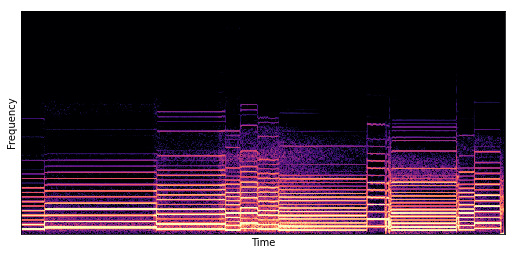

In [41]:
utils.specplot(audio_syn3)

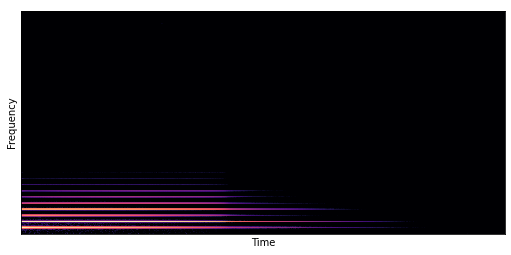

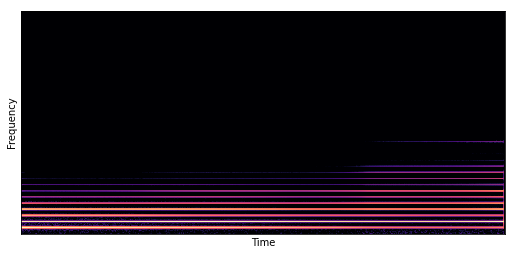

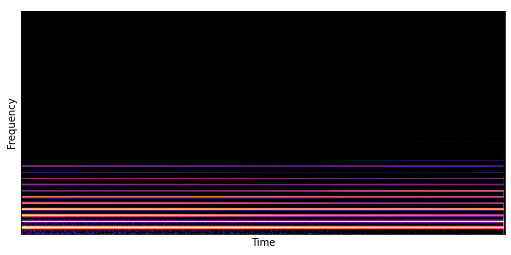

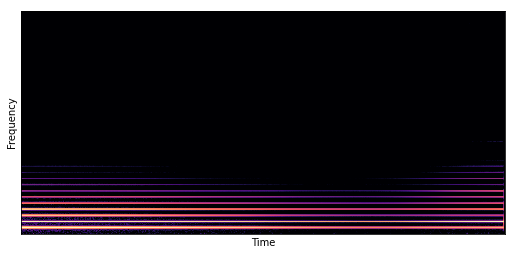

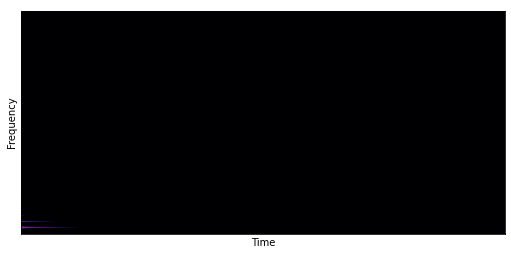

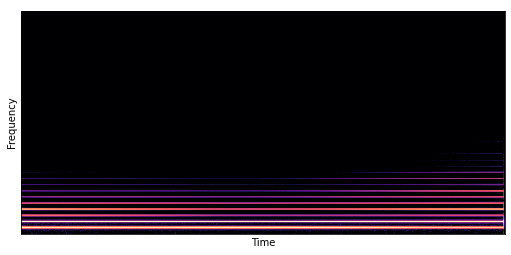

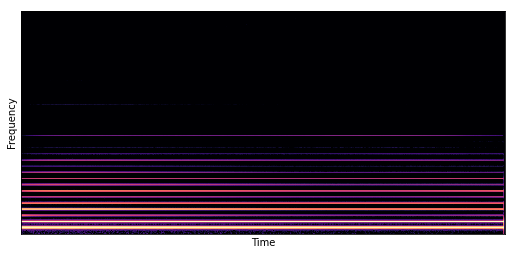

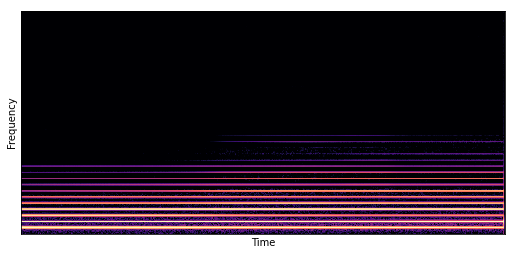

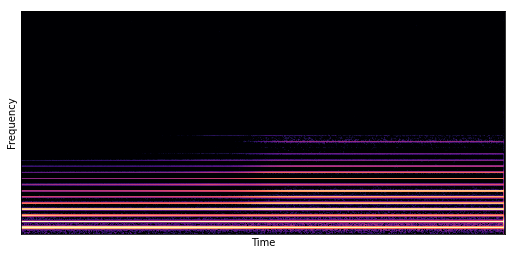

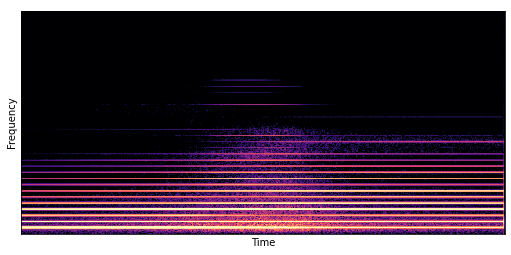

In [29]:
inputs4_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
inputs4 = dict([(k,[]) for k in inputs3_keys])

inputs4['ld_scaled'] = ld_scaled2 
inputs4['f0_scaled'] = f0_scaled2 
inputs4['f0_hz'] = f0_hz2

for k in np.arange(N_clusters):
    mu = gm.means_[k] 
    cov = gm.covariances_[k]

    for i in np.arange(16):
        normal_samples[0,:,i] = norm.ppf(uniform_samples, loc=mu[i], scale=np.sqrt(cov[i][i])) 

    inputs4['z'] = normal_samples
    pg_out4 = model_z.decode(inputs4,training = False) # pg = processor group
    audio_syn4 = pg_out4
    
    utils.specplot(audio_syn4)

## Comparing the results

In [34]:
print('Original')
ipd.Audio(audio, rate = sample_rate) 

Original


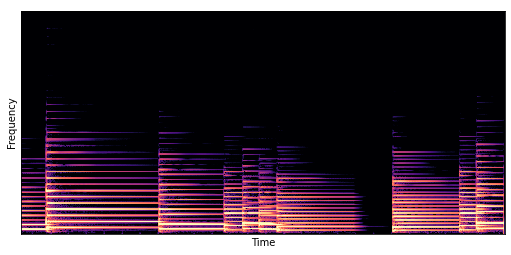

In [35]:
utils.specplot(audio)

In [36]:
print('Resynthesis with z encoder')
ipd.Audio(audio_gen_z, rate = sample_rate)

Resynthesis with z encoder


In [30]:
print('GMM')
ipd.Audio(audio_syn, rate = sample_rate)

GMM


In [31]:
print('fix z')
ipd.Audio(audio_syn1, rate = sample_rate)

fix z


In [32]:
print("fix f0 and loundness")
ipd.Audio(audio_syn2, rate = sample_rate)

fix f0 and loundness


In [33]:
print('z inverse transform sampling')
ipd.Audio(audio_syn3, rate = sample_rate)

z inverse transform sampling


**Save audios**

In [42]:
import soundfile as sf

audio_original_out = audio[0]
sf.write('audio_original.wav',audio_original_out, sample_rate)

audio_z_out = audio_gen_z[0]
sf.write('audio_z_DDSP.wav',audio_z_out, sample_rate)

audio_syn_out = audio_syn[0]
sf.write('audio_direct_sampling.wav',audio_syn_out, sample_rate)
print(np.shape(audio_syn_out))

audio_syn3_out = audio_syn3[0]
sf.write('audio_inverse_transform_sampling.wav',audio_syn3_out, sample_rate)

(160000,)
